<a href="https://colab.research.google.com/github/DivyaRoopa123/Intern-week--1/blob/main/week_2_task_1ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install -q scikit-learn pandas matplotlib seaborn joblib


import os
import zipfile
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score
import joblib


plt.rcParams['figure.figsize'] = (6,4)


In [ ]:

data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
zip_path = "smsspamcollection.zip"

print("Downloading dataset...")
urllib.request.urlretrieve(data_url, zip_path)
print("Downloaded:", zip_path)


with zipfile.ZipFile(zip_path, "r") as z:
    file_list = z.namelist()
    print("Files in zip:", file_list)

    fname = next((f for f in file_list if "SMSSpamCollection" in f or "smsspamcollection" in f.lower()), None)
    if fname is None:
        raise FileNotFoundError("SMSSpamCollection file not found inside zip")
    raw = z.read(fname).decode('utf-8', errors='replace')


rows = [line.split('\t', 1) for line in raw.strip().splitlines() if '\t' in line]
df = pd.DataFrame(rows, columns=['label','text'])
print("Dataset shape:", df.shape)
df.head(6)


Downloaded: smsspamcollection.zip
Files in zip: ['SMSSpamCollection', 'readme']
Dataset shape: (5574, 2)


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...


In [ ]:

print("Label counts:")
print(df['label'].value_counts())


print("\nMissing values per column:")
print(df.isnull().sum())

print("\nSample HAM examples:")
display(df[df['label']=='ham'].sample(3, random_state=1)['text'])
print("\nSample SPAM examples:")
display(df[df['label']=='spam'].sample(3, random_state=1)['text'])


Label counts:
label
ham     4827
spam     747
Name: count, dtype: int64

Missing values per column:
label    0
text     0
dtype: int64

Sample HAM examples:


,text
2535,Ok enjoy . R u there in home.
1213,"Yo, the game almost over? Want to go to walmar..."
522,Shall i come to get pickle



Sample SPAM examples:


,text
5494,Marvel Mobile Play the official Ultimate Spide...
1146,"Thank you, winner notified by sms. Good Luck! ..."
1699,"Free msg. Sorry, a service you ordered from 81..."


In [ ]:
import re
def clean_text(s):
    s = str(s)
    s = s.strip().lower()

    s = re.sub(r'\s+', ' ', s)

    s = ''.join(ch for ch in s if ord(ch) >= 32 and ord(ch) <= 126)
    return s

df['text_clean'] = df['text'].apply(clean_text)

# quick check
df[['text','text_clean']].head(6)


,text,text_clean
0,"Go until jurong point, crazy.. Available only ...","go until jurong point, crazy.. available only ..."
1,Ok lar... Joking wif u oni...,ok lar... joking wif u oni...
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,U dun say so early hor... U c already then say...,u dun say so early hor... u c already then say...
4,"Nah I don't think he goes to usf, he lives aro...","nah i don't think he goes to usf, he lives aro..."
5,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey there darling it's been 3 week's n...


In [ ]:
df['y'] = df['label'].map({'ham':0, 'spam':1}).astype(int)
X = df['text_clean'].values
y = df['y'].values


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", len(X_train), "Test size:", len(X_test))

print("Train label distribution:", np.bincount(y_train))
print("Test label distribution:", np.bincount(y_test))


Train size: 4459 Test size: 1115
Train label distribution: [3861  598]
Test label distribution: [966 149]


In [ ]:
tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    ngram_range=(1,2),
    max_df=0.95,
    min_df=2
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF shapes -> train:", X_train_tfidf.shape, " test:", X_test_tfidf.shape)


TF-IDF shapes -> train: (4459, 7238)  test: (1115, 7238)


In [ ]:

lr = LogisticRegression(max_iter=1000, solver='liblinear')  # solver liblinear works well here
lr.fit(X_train_tfidf, y_train)


joblib.dump(lr, "logistic_spam_model.joblib")
joblib.dump(tfidf, "tfidf_vectorizer.joblib")
print("Model and vectorizer saved to current directory.")


Model and vectorizer saved to current directory.


In [ ]:

y_pred = lr.predict(X_test_tfidf)
y_proba = lr.predict_proba(X_test_tfidf)[:,1]  # probability for positive class


acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['ham','spam'])

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}\n")
print("Classification report:\n", report)


cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix (rows = actual, cols = predicted):\n", cm)


Accuracy: 0.9767
Precision: 1.0000
Recall: 0.8255

Classification report:
               precision    recall  f1-score   support

         ham       0.97      1.00      0.99       966
        spam       1.00      0.83      0.90       149

    accuracy                           0.98      1115
   macro avg       0.99      0.91      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Confusion matrix (rows = actual, cols = predicted):
 [[966   0]
 [ 26 123]]


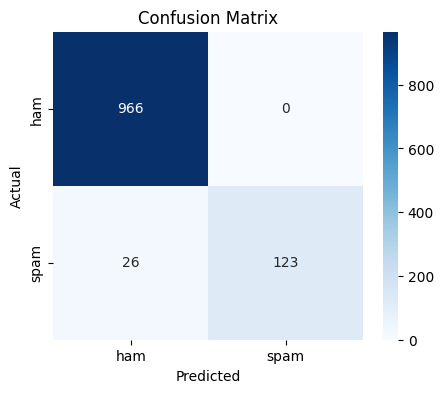

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ham','spam'], yticklabels=['ham','spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
feature_names = np.array(tfidf.get_feature_names_out())
coefs = lr.coef_[0]

top_spam = np.argsort(coefs)[-20:][::-1]
top_ham = np.argsort(coefs)[:20]

print("Top features indicating SPAM:")
for i in top_spam:
    print(f"{feature_names[i]:25s}  {coefs[i]:.4f}")

print("\nTop features indicating HAM:")
for i in top_ham:
    print(f"{feature_names[i]:25s}  {coefs[i]:.4f}")


Top features indicating SPAM:
txt                        4.1507
mobile                     3.5992
claim                      3.5071
uk                         3.2710
www                        3.2069
reply                      3.0601
free                       3.0374
stop                       3.0210
prize                      2.7234
service                    2.6848
150p                       2.6777
text                       2.5797
com                        2.4148
new                        2.3442
50                         2.3280
won                        2.2529
win                        2.1648
cash                       2.1422
18                         2.0985
urgent                     2.0325

Top features indicating HAM:
ok                         -1.9383
ll                         -1.6410
da                         -1.4814
come                       -1.4800
gt                         -1.4304
home                       -1.4266
got                        -1.4229
lt             

In [ ]:

with open("classification_report.txt", "w") as f:
    f.write(f"Accuracy: {acc:.4f}\nPrecision: {prec:.4f}\nRecall: {rec:.4f}\n\n")
    f.write(report)


plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['ham','spam'], yticklabels=['ham','spam'])
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.close()

print("Saved classification_report.txt and confusion_matrix.png in current directory.")


Saved classification_report.txt and confusion_matrix.png in current directory.
